In [2]:
from pathlib import Path
import gzip
from glob import glob
import os
import shutil
import urllib.request as request
from contextlib import closing
from datetime import datetime
from dateutil import tz

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import cf2cdm

In [3]:
# Download files

mrms = {
    'reflectivity_20deg_celsius': 'https://mrms.ncep.noaa.gov/data/2D/Reflectivity_-20C/MRMS_Reflectivity_-20C.latest.grib2.gz',
}

def download_mrms(file_url):
    file = file_url.split('/')[-1]
    grib2 = '.'.join(file.split('.')[0:-1])
    
    with closing(request.urlopen(file_url)) as r:
        with open(file, 'wb') as f:
            shutil.copyfileobj(r, f)
    
    with gzip.open(file, 'rb') as f_in:
        with open(grib2, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    shutil.move(grib2, f'data/')
    os.remove(file)

    
def clear_folder_contents(folder):
    '''
    Clears all contents of folder specified in the argument
    '''
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): 
                shutil.rmtree(file_path)
        except Exception as e:
            print(e)

    
# Clear directories before getting data
clear_folder_contents('data')
        
# Download the data
for grib2 in mrms.values():
    download_mrms(grib2)

In [5]:
# Read in files and acquire data needed for plotting

BOTTOM_LAT = 33
TOP_LAT = 37
LEFT_LON = 360-86
RIGHT_LON = 360-80

LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)
LON_SLICE = slice(LEFT_LON, RIGHT_LON)

ds = xr.load_dataset(glob('data/MRMS_Reflectivity_-20C*.grib2')[0], engine='cfgrib')
ds = ds.metpy.parse_cf()
ds = cf2cdm.translate_coords(ds, cf2cdm.CDS)

lats = ds.lat.sel(lat=LAT_SLICE)
lons = ds.lon.sel(lon=LON_SLICE)

mrms_values = ds.paramId_0.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE).squeeze().metpy.unit_array

def convert_datetime(mrms_time):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(mrms_time, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

VALID_TIME = convert_datetime(str(ds.time.values).split('.')[0])

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


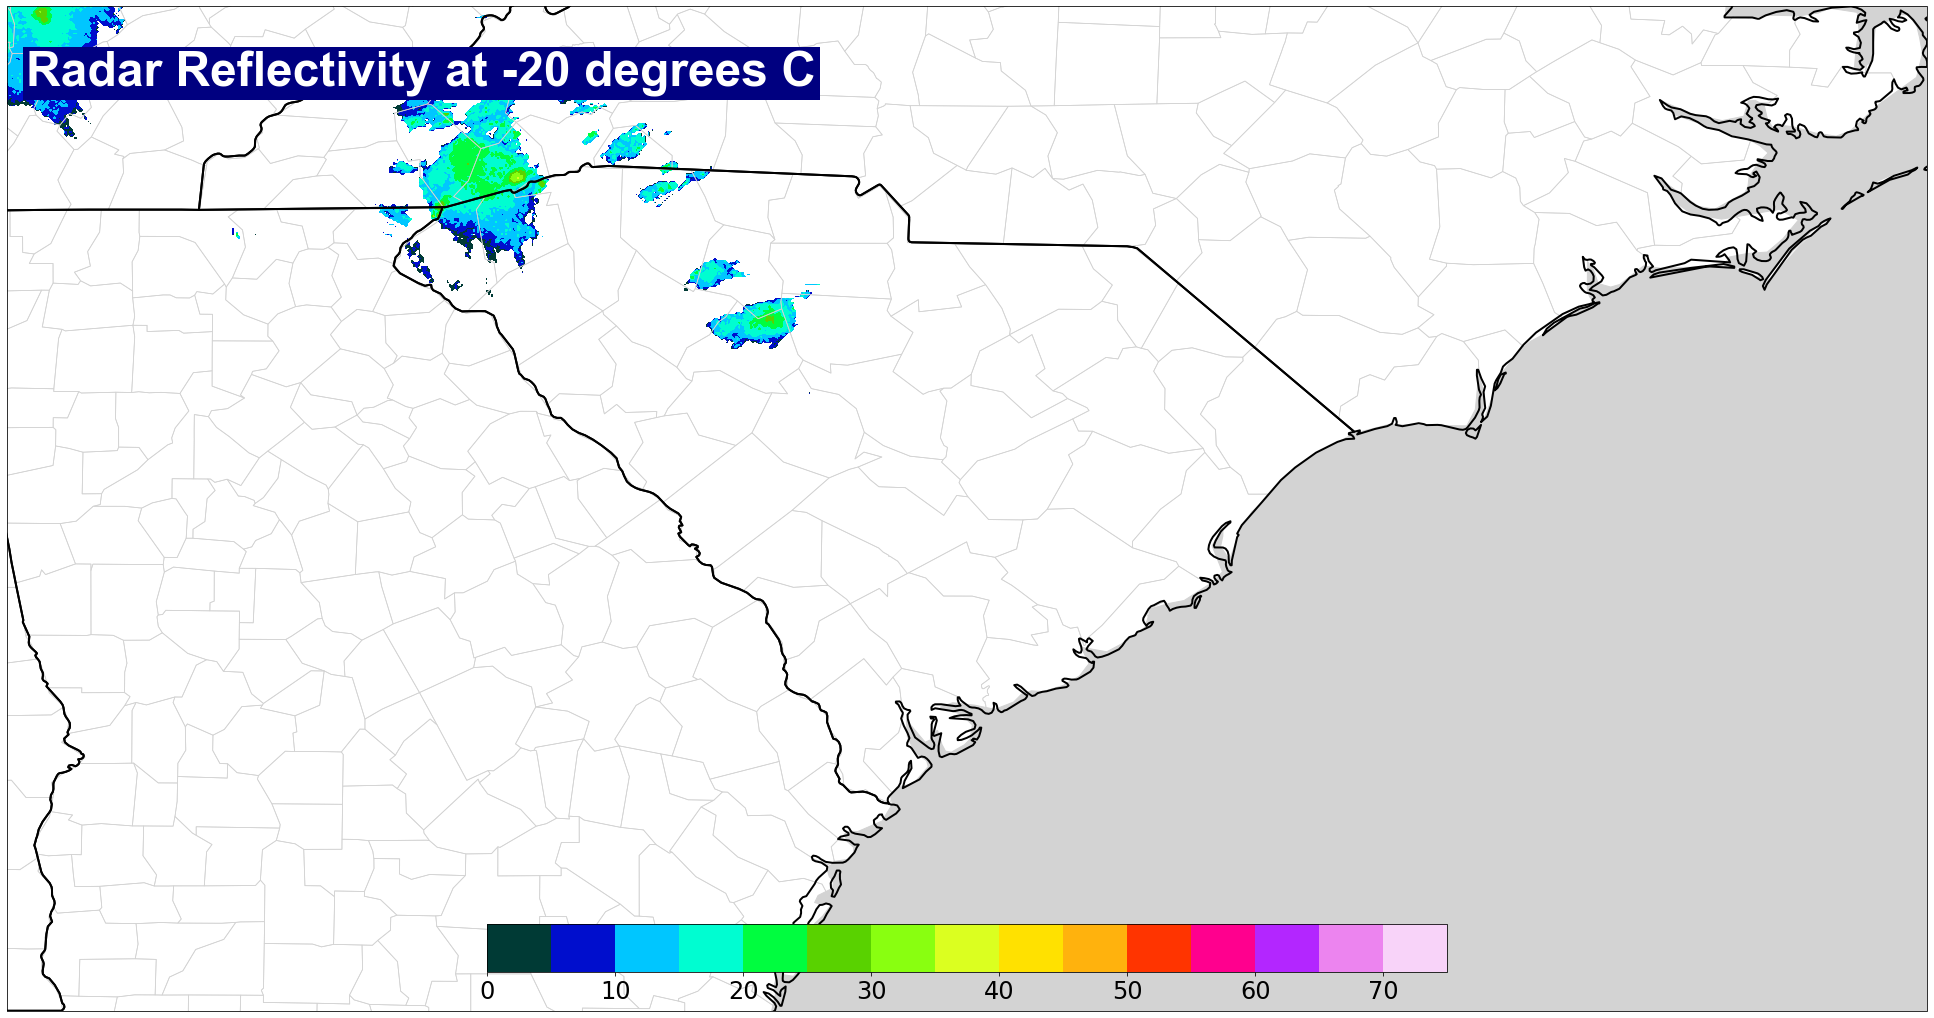

In [6]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
ax.set_extent([-82, -79, 31, 36])


range_reflectivity = [num for num in range(0, 80, 5)]
contour = ax.contourf(lons, lats, mrms_values, range_reflectivity, 
                     cmap=plt.cm.gist_ncar, transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title('Radar Reflectivity at -20 degrees C', loc='left', fontname='Arial',
             ha='left', va='top', fontsize=48, color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))


# Plot cities
# cities = {
#     'Pensacola': [30.4213, -87.2169],
#     'Tallahassee': [30.4383, -84.2807],
#     'Gainesville': [29.6516, -82.3248],
#     'Tampa': [27.9506, -82.4572],
#     'Orlando': [28.5383, -81.3792],
#     'Ft Myers': [26.6406, -81.8723],
#     'Miami': [25.7617, -80.1918],
#     'Key West': [24.5551, -81.7800]
# }

# def plot_cities(lat, lon, city_name):
#     ax.text(lon, lat, city_name, fontsize=28, zorder=10, fontweight='bold', fontname='Arial', backgroundcolor='black',
#             color='white', ha='center', transform=ccrs.PlateCarree())

# for city in cities.keys():
#     plot_cities(cities[city][0], cities[city][1], city)

# Save and show figure
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'mrms'
plt.savefig(f'{graphics_dir}/radar_reflectivity_-20C.png', dpi=72)
plt.show()